In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
torch.manual_seed(0)
import gpytorch

In [3]:
from src.data_generator import generate_1d_data, generate_2d_data
from src.data_generator import forrester_function, branin_function

from src.plot import plot_points_1d, plot_gp_1d, plot_2d_3d, plot_2d_2d, plot_2d_points

from src.gp_models import get_gp

from src.train import optimize_gp

from main import bo_with_outliers

## Example in 1D

In [4]:
x, y, outliers = generate_1d_data(n=300, n_out=6, alpha=1.3, xmin=0., xmax=.05, seed=5)

x_reg = x[~outliers]
y_reg = y[~outliers]

eps = .05
x_min = x.min() - eps
x_max = x.max() + eps
x_test = torch.linspace(x_min, x_max, 500)
y_test = forrester_function(x_test)

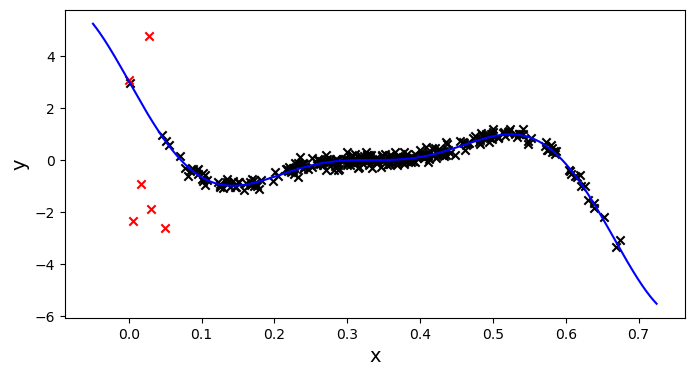

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
plot_points_1d(x, y, outliers, x_test, y_test, ax=ax)

In [6]:
KERNEL = "matern"
NITER = 1000
LR = .01

#### Gaussian Likelihood, Exact GP, no outliers

In [7]:
model_reg, likelihood_reg, obj_func_reg, optim_reg, predict_reg = get_gp("gaussian", x_reg, y_reg, lr=LR, kernel=KERNEL)

losses_reg = optimize_gp(model_reg, likelihood_reg, obj_func_reg, optim_reg, x_reg, y_reg, n_iter=NITER)

mean_reg, var_reg = predict_reg(model_reg, likelihood_reg, x_test)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:02<00:00, 364.67it/s, loss=-.376]


#### Gaussian Likelihood, Exact GP, with outliers

In [8]:
model_out, likelihood_out, obj_func_out, optim_out, predict_out = get_gp("gaussian", x, y, lr=LR, kernel=KERNEL)

losses_out = optimize_gp(model_out, likelihood_out, obj_func_out, optim_out, x, y, n_iter=NITER)

mean_out, var_out = predict_out(model_out, likelihood_out, x_test)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:02<00:00, 362.80it/s, loss=0.706]


#### Student-t Likelihood, Approximate GP

In [9]:
model_st, likelihood_st, obj_func_st, optim_st, predict_st = get_gp("studentT", x, y, lr=LR, kernel=KERNEL)

losses_st = optimize_gp(model_st, likelihood_st, obj_func_st, optim_st, x, y, n_iter=NITER)

mean_st, var_st = predict_st(model_st, likelihood_st, x_test)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:12<00:00, 78.49it/s, loss=-.162]


### Results

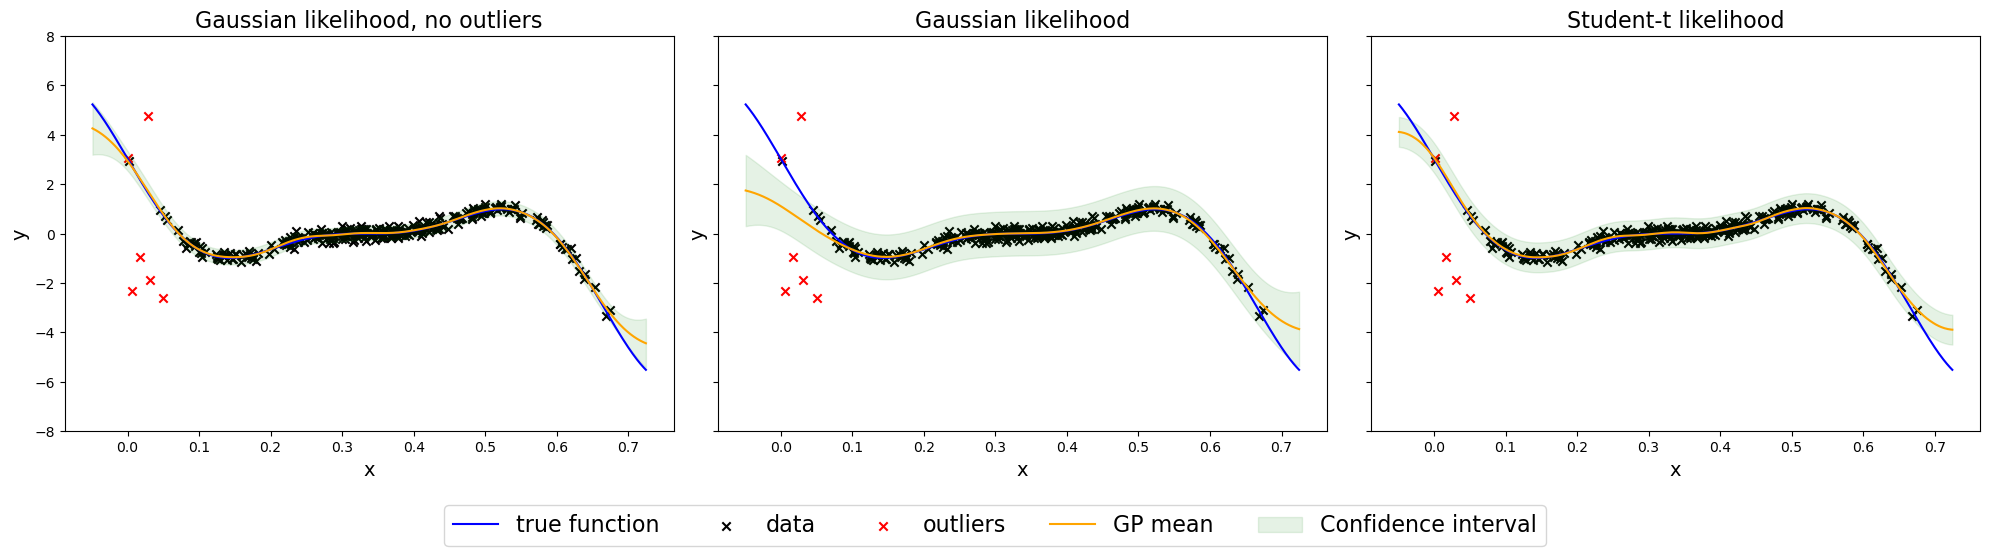

In [10]:
FONTSIZE = 16
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, sharey=True, figsize=(20, 5))
ax1.set_ylim(-8, 8)

plot_points_1d(x, y, outliers, x_test, y_test, ax=ax0)
plot_gp_1d(x_test, mean_reg, var_reg, ax=ax0)
ax0.set_title('Gaussian likelihood, no outliers', fontsize=FONTSIZE)

plot_points_1d(x, y, outliers, x_test, y_test, ax=ax1)
plot_gp_1d(x_test, mean_out, var_out, ax=ax1)
ax1.set_title('Gaussian likelihood', fontsize=FONTSIZE)

plot_points_1d(x, y, outliers, x_test, y_test, ax=ax2)
plot_gp_1d(x_test, mean_st.mean(0), var_st.mean(0), ax=ax2)
ax2.set_title('Student-t likelihood', fontsize=FONTSIZE)

# Create a legend for the whole figure
lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc='lower center', bbox_to_anchor=(0.5, -0.125), ncol=5, fontsize=16)

fig.tight_layout()
# fig.subplots_adjust(top=1.3)  # Adjust the bottom margin to make room for the legend

# plt.savefig('report/imgs/gp_1d.png', dpi=300, bbox_inches='tight')

## Example in 2D

In [11]:
xv, yv, x_test, y_test, x_train, y_train, outliers = generate_2d_data(
    n_points=100,
    n_outliers=25,
    alpha=50.,
    seed=10
)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

x_out = x_train[outliers]
y_out = y_train[outliers]

torch.Size([125, 2]) torch.Size([125]) torch.Size([961, 2]) torch.Size([961])


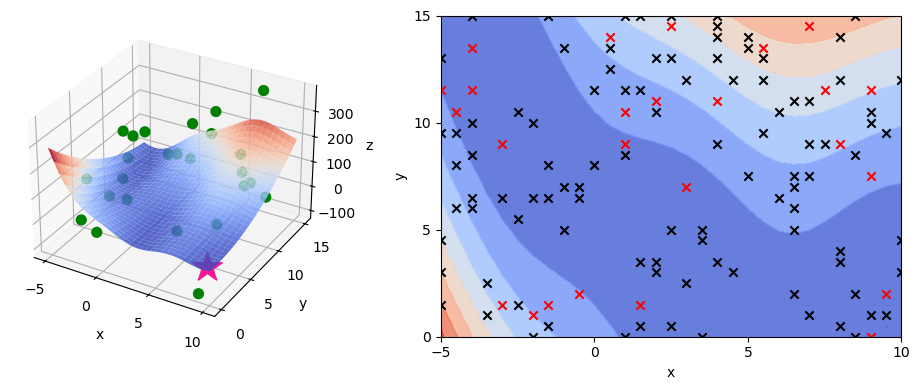

In [12]:
fig = plt.figure(figsize=(10, 4))

plot_2d_3d(xv, yv, y_test, 121, fig)
fig.get_axes()[0].scatter(x_out[:, 0], x_out[:, 1], y_out, c='green', marker='o', s=50, alpha=1.)

ax2 = fig.add_subplot(122)
plot_2d_2d(xv, yv, y_test, ax2)
plot_2d_points(x_train, y_train, outliers, ax2)

fig.tight_layout()

In [13]:
KERNEL = "matern"
NITER = 50000
LR = .01

In [18]:
model_reg, likelihood_reg, obj_func_reg, optim_reg, predict_reg = get_gp("gaussian", x_train, y_train, lr=LR, kernel=KERNEL)

losses_reg = optimize_gp(model_reg, likelihood_reg, obj_func_reg, optim_reg, x_train, y_train, n_iter=NITER)

mean_reg, var_reg = predict_reg(model_reg, likelihood_reg, x_test)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 50001/50001 [01:01<00:00, 809.96it/s, loss=6.92]


In [19]:
model_out, likelihood_out, obj_func_out, optim_out, predict_out = get_gp("gaussian", x_train, y_train, lr=LR, kernel=KERNEL)

losses_out = optimize_gp(model_out, likelihood_out, obj_func_out, optim_out, x_train, y_train, n_iter=NITER)

mean_out, var_out = predict_out(model_out, likelihood_out, x_test)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 50001/50001 [01:12<00:00, 693.67it/s, loss=6.92]


In [20]:
model_st, likelihood_st, obj_func_st, optim_st, predict_st = get_gp("studentT", x_train, y_train, lr=LR, kernel=KERNEL)

losses_st = optimize_gp(model_st, likelihood_st, obj_func_st, optim_st, x_train, y_train, n_iter=NITER)

mean_st, var_st = predict_st(model_st, likelihood_st, x_test)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 50001/50001 [03:32<00:00, 235.01it/s, loss=5.35]


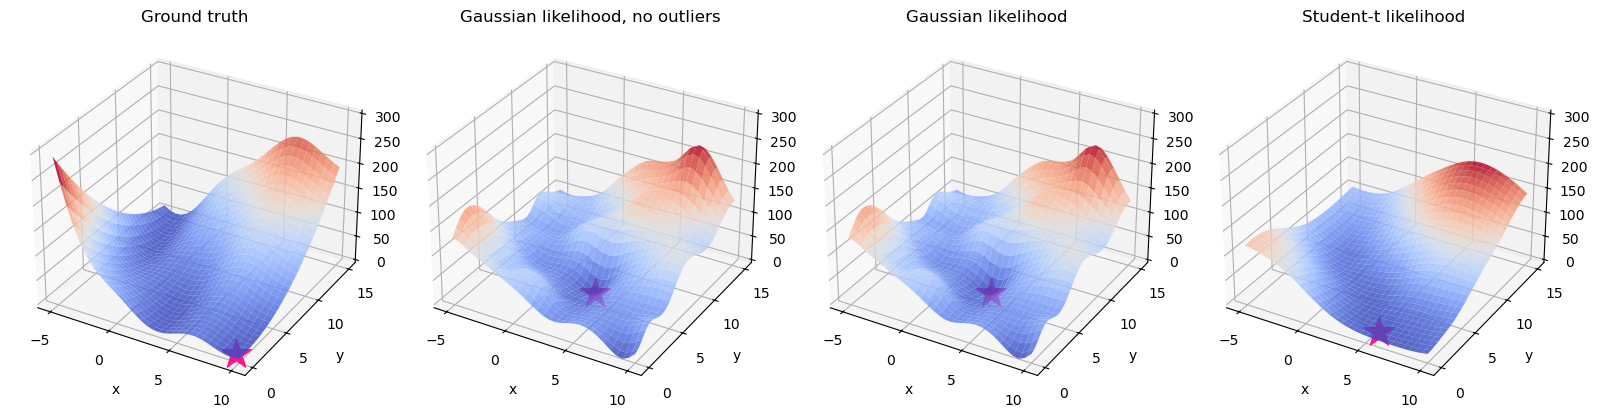

In [21]:
fig = plt.figure(figsize=(16, 4))
FONTSIZE = 12

plot_2d_3d(xv, yv, y_test, 141, fig)

plot_2d_3d(xv, yv, mean_reg, 142, fig)

plot_2d_3d(xv, yv, mean_out, 143, fig)

plot_2d_3d(xv, yv, mean_st.mean(0), 144, fig)

axes = fig.get_axes()
axes[0].set_title('Ground truth', fontsize=FONTSIZE)
# axes[0].scatter(x_out[:, 0], x_out[:, 1], y_out, c='green', marker='o', s=50, alpha=1.)
axes[1].set_title('Gaussian likelihood, no outliers', fontsize=FONTSIZE)
axes[2].set_title('Gaussian likelihood', fontsize=FONTSIZE)
axes[3].set_title('Student-t likelihood', fontsize=FONTSIZE)

zlim = (0, 300)
for ax in axes:
    ax.set_zlim(zlim)
    
fig.tight_layout()

plt.savefig('report/imgs/gp_2d.png', dpi=300, bbox_inches='tight')

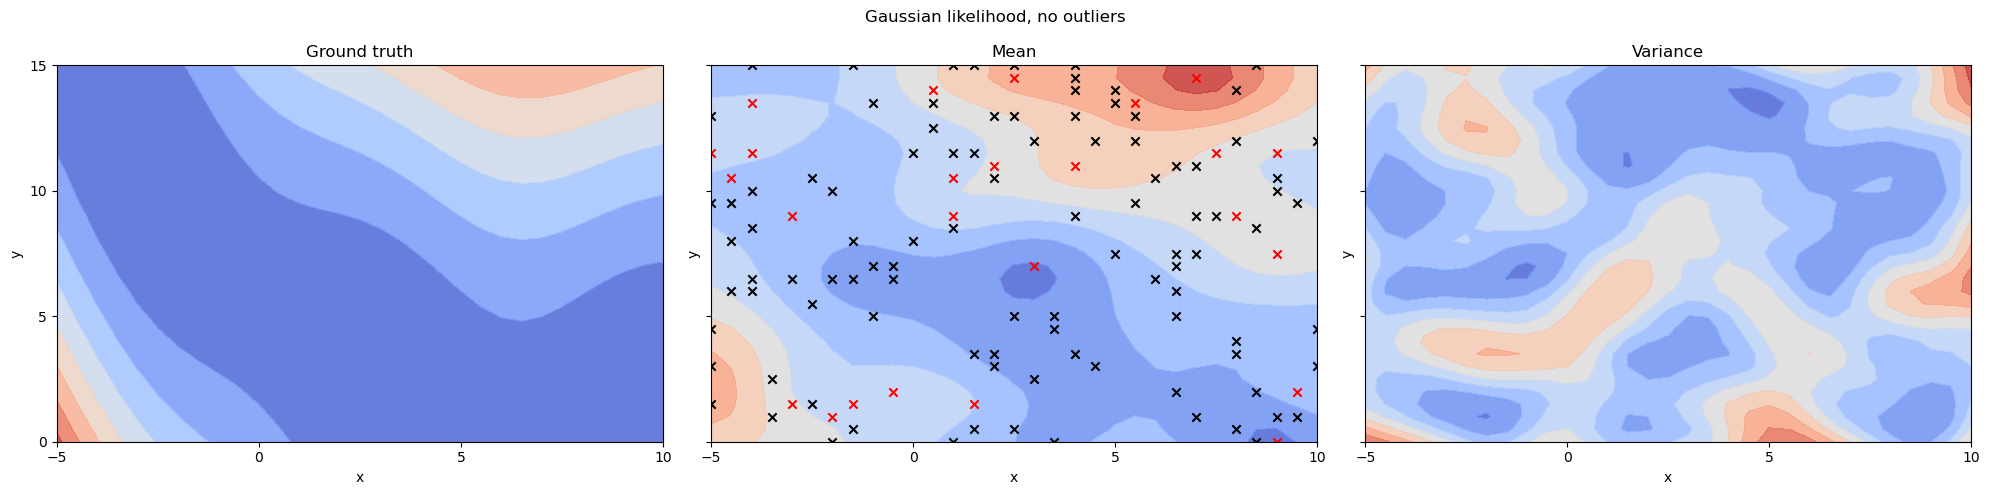

In [25]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, sharey=True, figsize=(20, 5))

plot_2d_2d(xv, yv, y_test, ax=ax0)

plot_2d_2d(xv, yv, mean_reg, ax=ax1)
plot_2d_points(x_train, y_train, outliers, ax=ax1)

plot_2d_2d(xv, yv, var_reg, ax=ax2)

ax0.set_title('Ground truth', fontsize=FONTSIZE)
ax1.set_title('Mean', fontsize=FONTSIZE)
ax2.set_title('Variance', fontsize=FONTSIZE)
plt.suptitle('Gaussian likelihood, no outliers', fontsize=FONTSIZE)
fig.tight_layout()

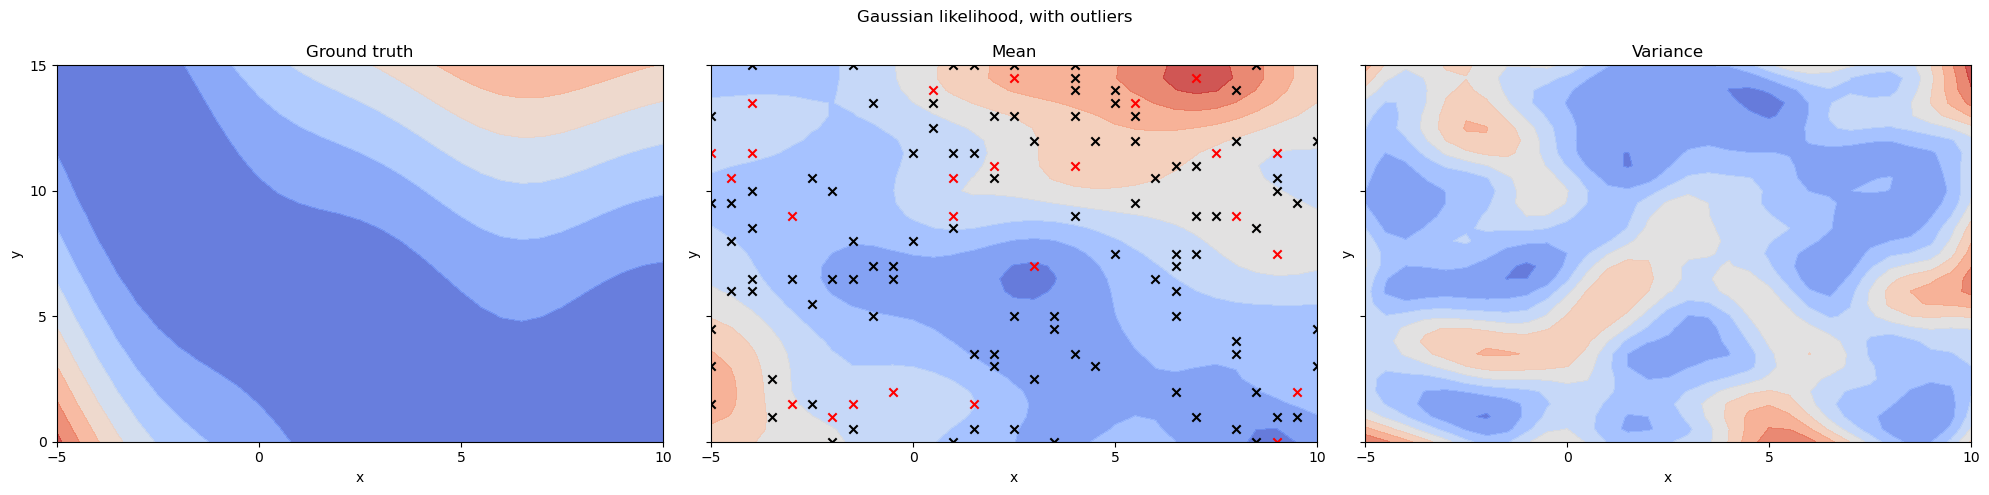

In [27]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, sharey=True, figsize=(20, 5))

plot_2d_2d(xv, yv, y_test, ax=ax0)

plot_2d_2d(xv, yv, mean_out, ax=ax1)
plot_2d_points(x_train, y_train, outliers, ax=ax1)

plot_2d_2d(xv, yv, var_out, ax=ax2)

ax0.set_title('Ground truth', fontsize=FONTSIZE)
ax1.set_title('Mean', fontsize=FONTSIZE)
ax2.set_title('Variance', fontsize=FONTSIZE)
plt.suptitle('Gaussian likelihood, with outliers', fontsize=FONTSIZE)
fig.tight_layout()

## GP with Student-t Likelihood computed with Laplace approximation

In [29]:
x, y, outliers = generate_1d_data(n=300, n_out=6, alpha=1.3, xmin=0., xmax=.05, seed=5)

x_reg = x[~outliers]
y_reg = y[~outliers]

eps = .05
x_min = x.min() - eps
x_max = x.max() + eps
x_test = torch.linspace(x_min, x_max, 500)
y_test = forrester_function(x_test)

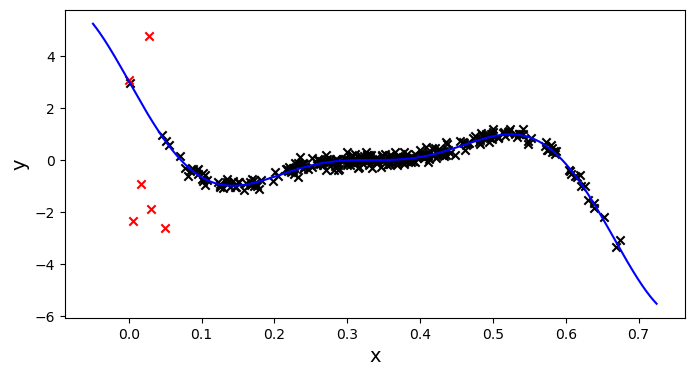

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
plot_points_1d(x, y, outliers, x_test, y_test, ax=ax)

In [31]:
KERNEL = "matern"
NITER = 1000
LR = .01

#### Gaussian Likelihood, Exact GP, with outliers
model_out, likelihood_out, obj_func_out, optim_out, predict_out = get_gp("gaussian", x, y, lr=LR, kernel=KERNEL)

losses_out = optimize_gp(model_out, likelihood_out, obj_func_out, optim_out, x, y, n_iter=NITER)

mean_out, var_out = predict_out(model_out, likelihood_out, x_test)

#### Student-t Likelihood, Approximate GP
model_st, likelihood_st, obj_func_st, optim_st, predict_st = get_gp("studentT", x, y, lr=LR, kernel=KERNEL)

losses_st = optimize_gp(model_st, likelihood_st, obj_func_st, optim_st, x, y, n_iter=NITER)

mean_st, var_st = predict_st(model_st, likelihood_st, x_test)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:13<00:00, 72.67it/s, loss=-.162]


In [32]:
model_out.eval()
with torch.no_grad():
    kernel_mat = model_out.covar_module(x).evaluate()
    f = model_out(x).mean.detach()

/Users/thomasgaviard/miniconda3/envs/bl/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [33]:
from src.train import em

In [34]:
f_hat, errors = em(x, y, f, kernel_mat, nu=1, sigma=1, n_iter=1000, eps_conv=1e-3)

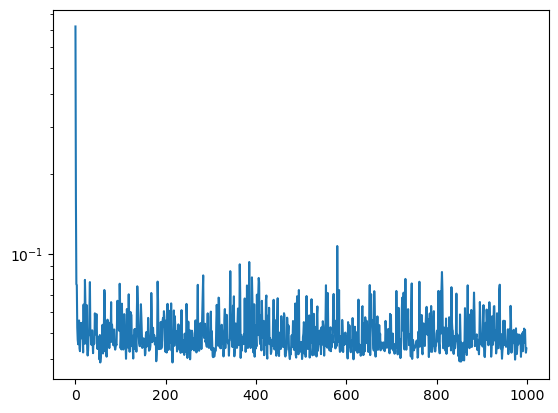

In [35]:
plt.plot(errors)
plt.yscale('log')

In [36]:
def compute_w(y, f, nu, sigma):
    r = (f - y) ** 2
    return torch.diag(- (nu + 1) * (r ** 2 - nu * sigma ** 2) / (nu * sigma ** 2 + r ** 2) ** 2)

In [37]:
w = compute_w(y, f_hat, nu=1, sigma=1)

In [38]:
def pred_distrib(f_hat, kernel_mat, w, x_q, x, model):
    with torch.no_grad():
        k1 = model.covar_module(x_q).evaluate().diag()
        k2 = model.covar_module(x_q, x).evaluate()
    post_mean = k2 @ kernel_mat.inverse() @ f_hat
    post_var = k1 - (k2 @ (kernel_mat + w.inverse()).inverse() @ k2.T).diag()
    return post_mean, post_var

In [39]:
post_mean_st, post_var_st = pred_distrib(f_hat, kernel_mat, w, x_test, x, model_out)

In [ ]:
FONTSIZE = 16
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(20, 5))
ax1.set_ylim(-8, 8)

plot_points_1d(x, y, outliers, x_test, y_test, ax=ax1)
plot_gp_1d(x_test, mean_out, var_out, ax=ax1)
ax1.set_title('Gaussian likelihood', fontsize=FONTSIZE)

plot_points_1d(x, y, outliers, x_test, y_test, ax=ax2)
plot_gp_1d(x_test, mean_st.mean(0), var_st.mean(0), ax=ax2)
ax2.set_title('Student-t likelihood, with VI', fontsize=FONTSIZE)

plot_points_1d(x, y, outliers, x_test, y_test, ax=ax3)
plot_gp_1d(x_test, post_mean_st, post_var_st, ax=ax3)
ax0.set_title('Student-t likelihood, Laplace approximation', fontsize=FONTSIZE)

# Create a legend for the whole figure
lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc='lower center', bbox_to_anchor=(0.5, -0.125), ncol=5, fontsize=16)

fig.tight_layout()
# fig.subplots_adjust(top=1.3)  # Adjust the bottom margin to make room for the legend

# plt.savefig('report/imgs/gp_1d.png', dpi=300, bbox_inches='tight')